Запуск симуляции клеточного автомата...

Обработка вероятности возгорания: 2e-05
  Статистика для окрестности CROSS (фон-Неймана)...


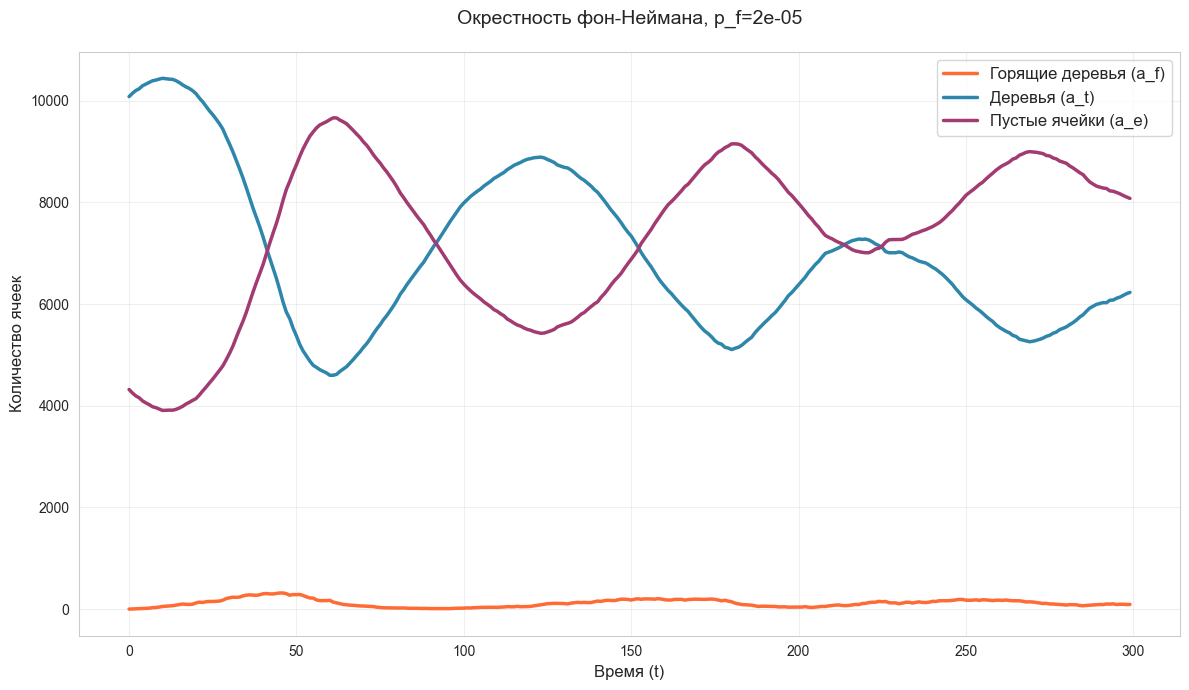

  Статистика для окрестности NEUMAN (Мура)...


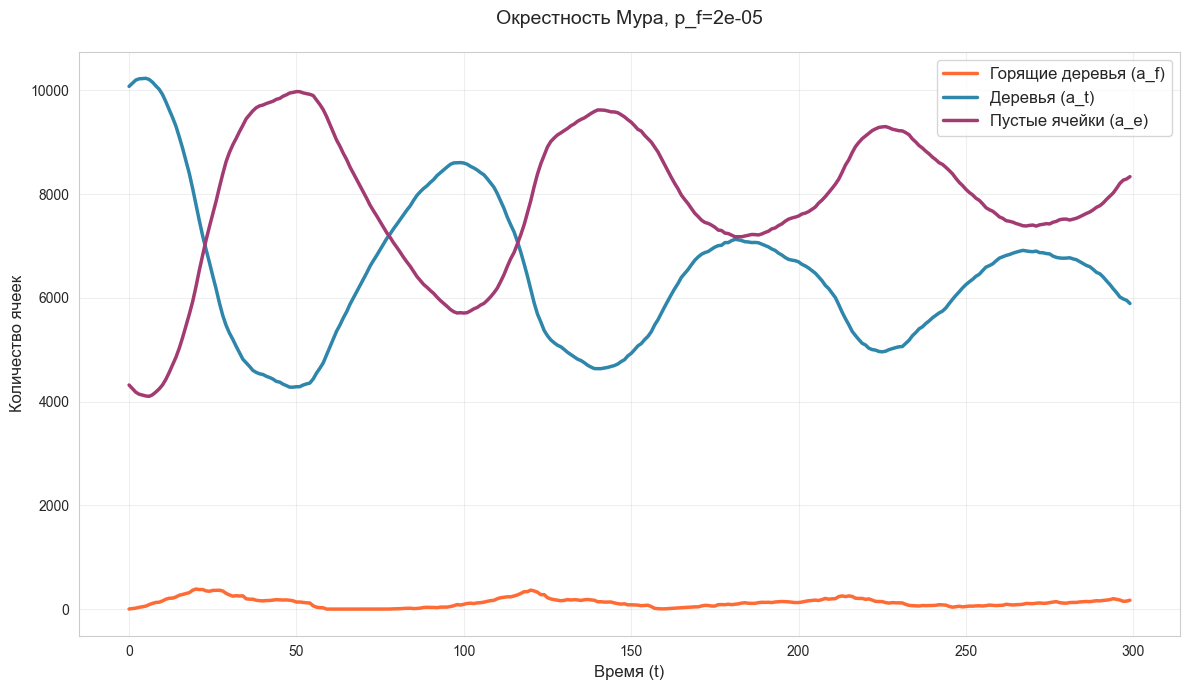

  Анимация для CROSS...
Анимация сохранена: cross_fire_2e-05.gif
  Анимация для NEUMAN...
Анимация сохранена: neuman_fire_2e-05.gif

Обработка вероятности возгорания: 3e-05
  Статистика для окрестности CROSS (фон-Неймана)...


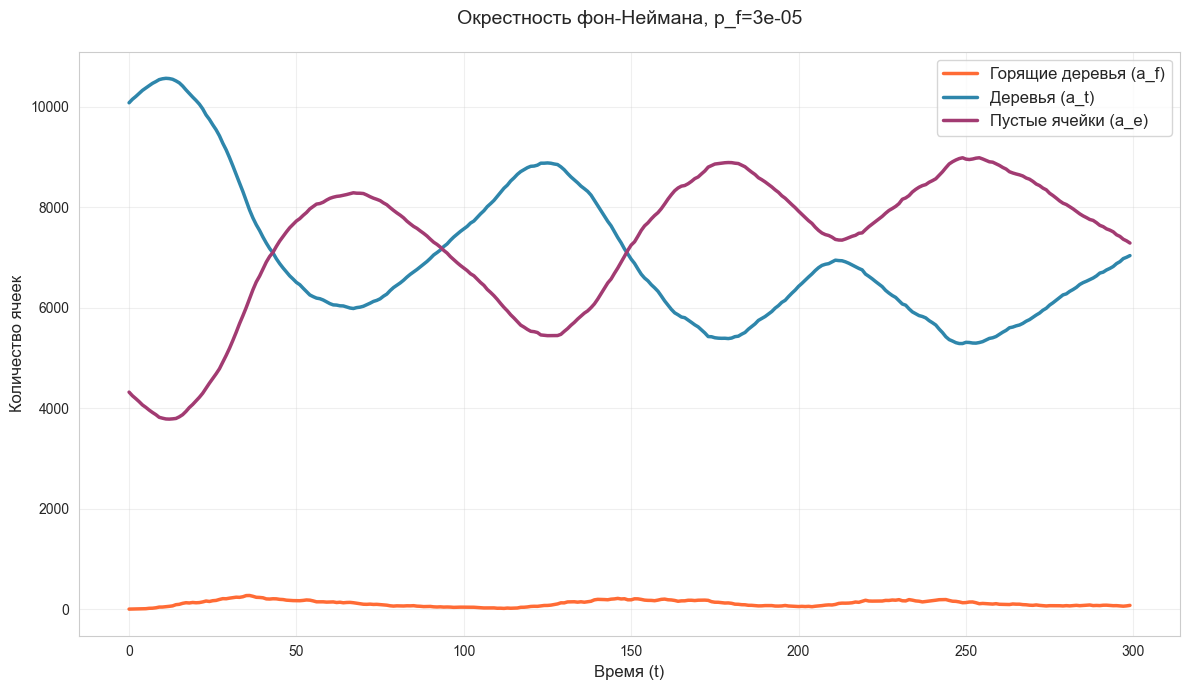

  Статистика для окрестности NEUMAN (Мура)...


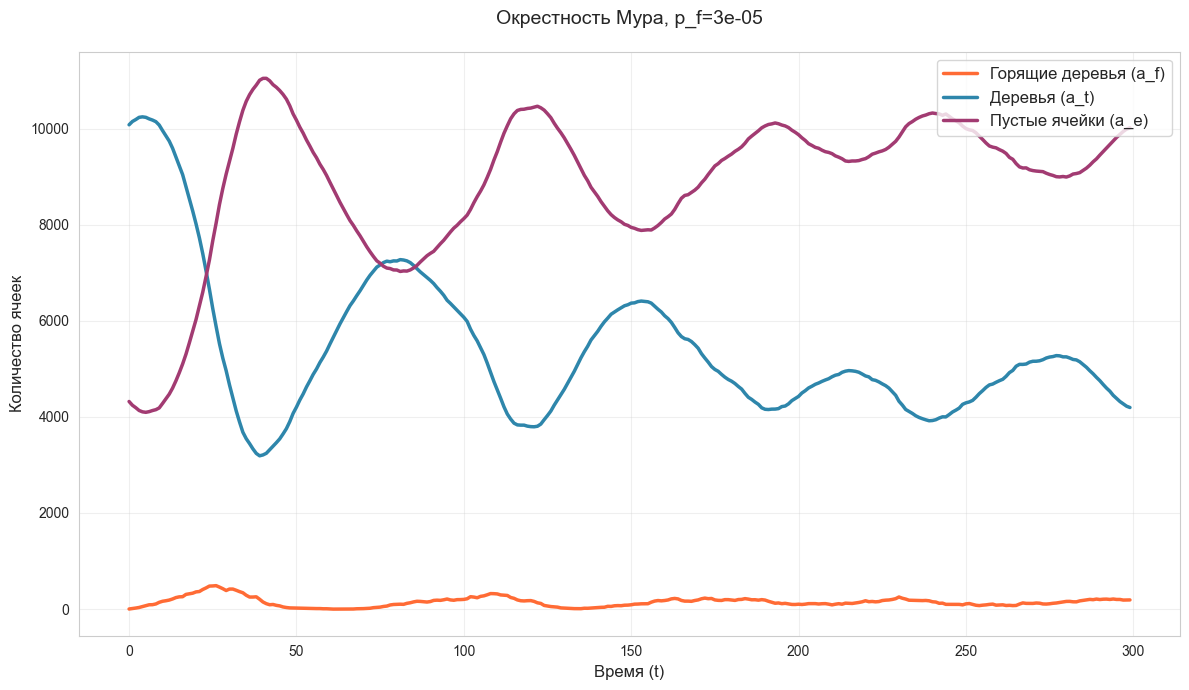

  Анимация для CROSS...
Анимация сохранена: cross_fire_3e-05.gif
  Анимация для NEUMAN...
Анимация сохранена: neuman_fire_3e-05.gif

Обработка вероятности возгорания: 4e-05
  Статистика для окрестности CROSS (фон-Неймана)...


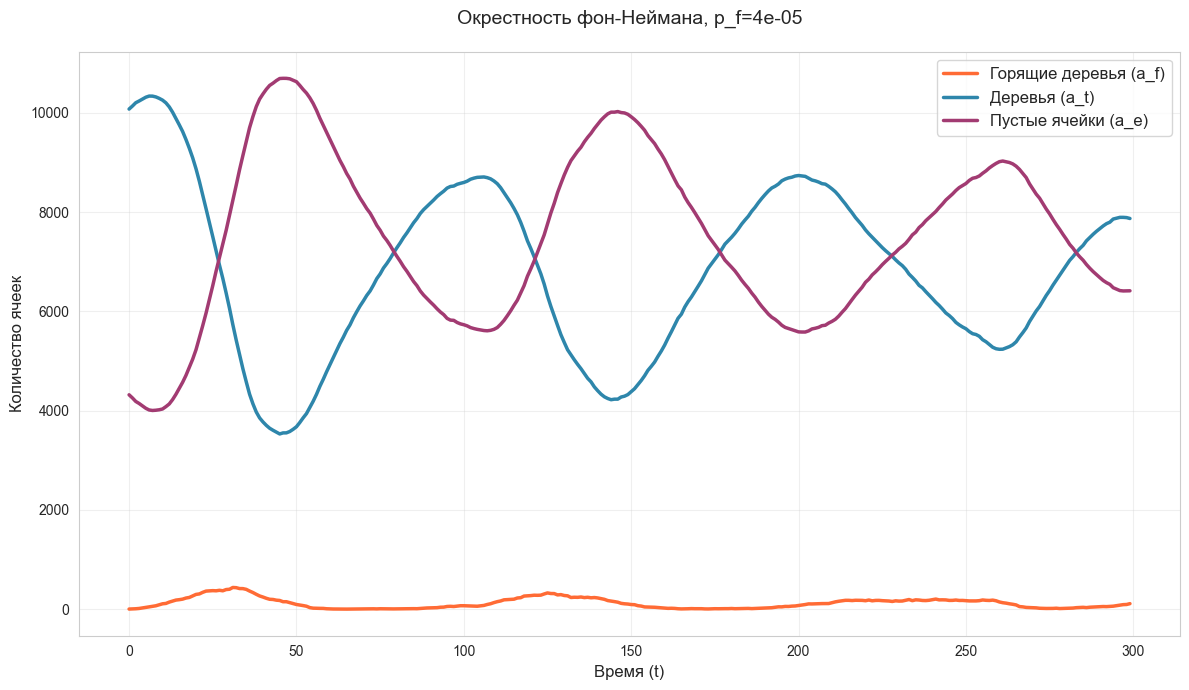

  Статистика для окрестности NEUMAN (Мура)...


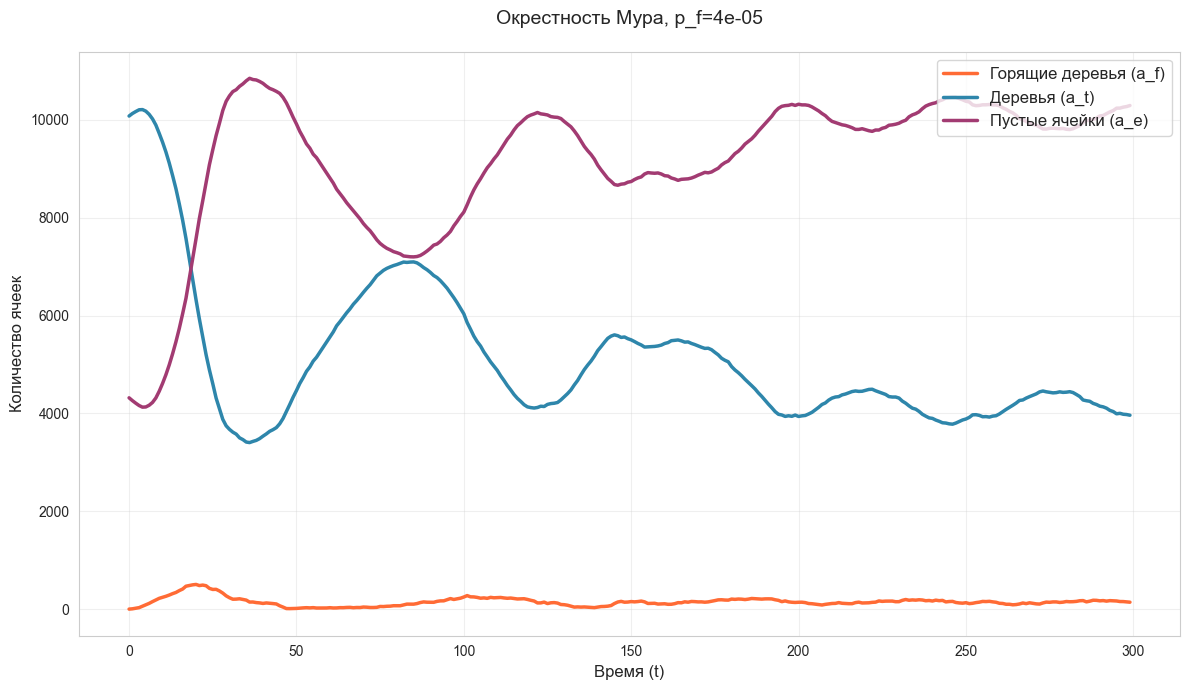

  Анимация для CROSS...
Анимация сохранена: cross_fire_4e-05.gif
  Анимация для NEUMAN...
Анимация сохранена: neuman_fire_4e-05.gif

Симуляция завершена! Создано:
- 6 графиков (3 вероятности × 2 окрестности)
- 6 GIF-анимаций (3 вероятности × 2 окрестности)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from enum import IntEnum
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
from scipy import ndimage

class NeighborhoodType(IntEnum):
    CROSS = 0     # фон-Неймана (+)
    NEUMAN = 1    # Мура (x)

class CellType(IntEnum):
    EMPTY = 0     # пустая ячейка (пепел)
    FIRING = 1    # горящее дерево
    TREE = 2      # дерево

def create_ca(rows, cols):
    return np.zeros((rows, cols), dtype=np.int8)

def init_state(grid, density, initial_fires, random_gen):
    rows, cols = grid.shape
    total_cells = rows * cols
    tree_cells = int(density * total_cells)

    positions = random_gen.choice(total_cells, tree_cells, replace=False)
    grid.flat[positions] = CellType.TREE

    fire_positions = random_gen.choice(positions, initial_fires, replace=False)
    grid.flat[fire_positions] = CellType.FIRING

    return grid

def get_neighborhood_kernel(neighborhood_type):
    if neighborhood_type == NeighborhoodType.CROSS:  # фон-Неймана
        return np.array([[0, 1, 0],
                         [1, 0, 1],
                         [0, 1, 0]])
    else:  # Мура
        return np.array([[1, 1, 1],
                         [1, 0, 1],
                         [1, 1, 1]])

def update_ca(grid, neighborhood_type, random_gen, ignite_chance, growth_chance):
    kernel = get_neighborhood_kernel(neighborhood_type)

    firing_neighbors = ndimage.convolve(
        (grid == CellType.FIRING).astype(int),
        kernel,
        mode='constant'
    )

    new_grid = grid.copy()

    firing_mask = grid == CellType.FIRING
    tree_mask = grid == CellType.TREE
    empty_mask = grid == CellType.EMPTY

    tree_burns = (firing_neighbors > 0) | (random_gen.random(grid.shape) < ignite_chance)
    new_grid[tree_mask & tree_burns] = CellType.FIRING

    new_grid[firing_mask] = CellType.EMPTY

    can_grow = (firing_neighbors == 0) & (random_gen.random(grid.shape) < growth_chance)
    new_grid[empty_mask & can_grow] = CellType.TREE

    return new_grid

class Statistics:
    def __init__(self):
        self.time_steps = []
        self.a_f = []
        self.a_t = []
        self.a_e = []

    def record(self, time_step, grid):
        self.time_steps.append(time_step)
        self.a_f.append((grid == CellType.FIRING).sum())
        self.a_t.append((grid == CellType.TREE).sum())
        self.a_e.append((grid == CellType.EMPTY).sum())

def simulate(initial_grid, n_type, rand_gen, ignite_rate, growth_rate, duration):
    stats = Statistics()
    current_grid = initial_grid.copy()

    for step in range(duration):
        stats.record(step, current_grid)
        current_grid = update_ca(current_grid, n_type, rand_gen, ignite_rate, growth_rate)

    return stats

def plot_statistics(stats, plot_title):
    plt.figure(figsize=(12, 7))

    plt.plot(stats.time_steps, stats.a_f,
             color='#FF6B35', linewidth=2.5, label='Горящие деревья (a_f)')
    plt.plot(stats.time_steps, stats.a_t,
             color='#2E86AB', linewidth=2.5, label='Деревья (a_t)')
    plt.plot(stats.time_steps, stats.a_e,
             color='#A23B72', linewidth=2.5, label='Пустые ячейки (a_e)')

    plt.legend(fontsize=12, loc='upper right')
    plt.title(plot_title, fontsize=14, pad=20)
    plt.xlabel('Время (t)', fontsize=12)
    plt.ylabel('Количество ячеек', fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def create_forest_fire_gif(initial_grid, n_type, rand_gen, ignite_rate, growth_rate,
                           duration, frame_interval=50, output_file="forest_fire.gif"):

    fig, ax = plt.subplots(figsize=(8, 8))
    custom_palette = ListedColormap(['#4A4A4A', '#FF9505', '#00743F'])

    current_state = initial_grid.copy()
    image = ax.imshow(current_state, cmap=custom_palette)
    time_label = ax.set_title("")

    ax.set_xlabel("Ширина", fontsize=11)
    ax.set_ylabel("Высота", fontsize=11)

    def update_frame(time_step):
        nonlocal current_state
        ax.set_title(f"Шаг времени: {time_step}", fontsize=13)
        image.set_array(current_state)
        current_state = update_ca(current_state, n_type, rand_gen, ignite_rate, growth_rate)
        return [image, time_label]

    frames_to_save = min(duration, 150)
    step = max(1, duration // frames_to_save)

    anim = animation.FuncAnimation(fig, update_frame, frames=range(0, duration, step),
                                   interval=frame_interval, blit=True)
    anim.save(output_file, writer='pillow', dpi=80)
    plt.close()
    print(f"Анимация сохранена: {output_file}")


w, h = 120, 120
density = 0.7
initial_fires = 2
p_g = 0.015
p_f_values = [2e-5, 3e-5, 4e-5]
sim_time = 300
anim_time = 150
seed = 1097

print("Запуск симуляции клеточного автомата...")

for i, p_f in enumerate(p_f_values):
    print(f"\nОбработка вероятности возгорания: {p_f}")

    rand_state = np.random.RandomState(seed + i)
    ca = create_ca(h, w)
    ca = init_state(ca, density, initial_fires, rand_state)

    print("  Статистика для окрестности CROSS (фон-Неймана)...")
    stats_cross = simulate(ca.copy(), NeighborhoodType.CROSS, rand_state, p_f, p_g, sim_time)
    plot_statistics(stats_cross, f'Окрестность фон-Неймана, p_f={p_f}')

    print("  Статистика для окрестности NEUMAN (Мура)...")
    stats_neuman = simulate(ca.copy(), NeighborhoodType.NEUMAN, rand_state, p_f, p_g, sim_time)
    plot_statistics(stats_neuman, f'Окрестность Мура, p_f={p_f}')

    print("  Анимация для CROSS...")
    create_forest_fire_gif(ca.copy(), NeighborhoodType.CROSS, rand_state,
                           p_f, p_g, anim_time, output_file=f"cross_fire_{p_f}.gif")

    print("  Анимация для NEUMAN...")
    create_forest_fire_gif(ca.copy(), NeighborhoodType.NEUMAN, rand_state,
                           p_f, p_g, anim_time, output_file=f"neuman_fire_{p_f}.gif")

print("\nСимуляция завершена! Создано:")
print("- 6 графиков (3 вероятности × 2 окрестности)")
print("- 6 GIF-анимаций (3 вероятности × 2 окрестности)")
